## This is the first notebook done after the hackathon
### I'm using a different approach to calculating features (more array and vector based and less row and loop based) which is speeding up the calculation. 
### The thought process is the same
#### - Justin

In [54]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
welly.__version__

'0.3.0'

In [3]:
%%timeit
import os
env = %env


10000 loops, best of 3: 92.8 µs per loop


In [4]:
from IPython.display import display

In [5]:
pd.set_option('display.max_rows', 2000)
## pd.set_option('display.height', 2000)

## Notes

In [6]:
## for finding similar geographic points
## scipy spatial kd tree - similar to quad tree ... CKD tree is a little faster as its the C version
## scipy.spatial
## spatial 
## asdfds
##  
## tree.query

## Read In Some Data

In [7]:
## Modifying this slightly to bring in the base McMurray as well
## If we use that as a "pick we already have" it will make the training easier for the "top McMurray" pick.
picks_dic = pd.read_csv('./SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('./SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('./SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
picks_new=picks[picks['HorID']==13000]
picks_paleoz=picks[picks['HorID']==14000]
df_new = pd.merge(wells, picks_new, on='SitID')
df_paleoz = pd.merge(wells, picks_paleoz, on='SitID')
df_new=pd.merge(df_paleoz, df_new, on='SitID')
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2


In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 2192
Data columns (total 11 columns):
SitID          2193 non-null int64
UWI (AGS)_x    2193 non-null object
UWI_x          2193 non-null object
HorID_x        2193 non-null int64
Pick_x         2193 non-null object
Quality_x      2193 non-null int64
UWI (AGS)_y    2193 non-null object
UWI_y          2193 non-null object
HorID_y        2193 non-null int64
Pick_y         2193 non-null object
Quality_y      2193 non-null int64
dtypes: int64(5), object(6)
memory usage: 205.6+ KB


In [9]:


df_new = df_new[["SitID","UWI (AGS)_x","UWI_x","HorID_x","Pick_x","Quality_x","HorID_y","Pick_y","Quality_y"]]
df_new["UWI (AGS)"] = df_new["UWI (AGS)_x"]
df_new["UWI"] = df_new["UWI_x"]
df_new["HorID"] = df_new["HorID_y"]
df_new["Pick"] = df_new["Pick_y"]
df_new["Quality"] = df_new["Quality_y"]
df_new["HorID_paleoz"] = df_new["HorID_x"]
df_new["Pick_paleoz"] = df_new["Pick_x"]
df_new["Quality_paleoz"] = df_new["Quality_x"]
df_new = df_new[["SitID","UWI (AGS)","UWI","HorID","Pick","Quality","HorID_paleoz","Pick_paleoz","Quality_paleoz"]]
df_new

,SitID,UWI (AGS),UWI,HorID,Pick,Quality,HorID_paleoz,Pick_paleoz,Quality_paleoz
0,102496,0674010812000,00/12-08-067-01W4/0,13000,475,3,14000,561,1
1,102497,0674020807000,00/07-08-067-02W4/0,13000,515,3,14000,604.5,1
2,102498,0674021109000,00/09-11-067-02W4/0,13000,480,3,14000,564,1
3,102500,0674022910000,00/10-29-067-02W4/0,13000,549,3,14000,636.5,1
4,102501,0674023406000,00/06-34-067-02W4/0,13000,529,2,14000,613,1
5,102503,0674030411000,00/11-04-067-03W4/0,13000,488.5,2,14000,553.5,1
6,102505,0674030810000,00/10-08-067-03W4/0,13000,501.5,2,14000,572.5,1
7,102507,0674031410000,00/10-14-067-03W4/0,13000,553.5,2,14000,606.5,1
8,102514,0674032810000,00/10-28-067-03W4/0,13000,493.5,3,14000,558,1
9,102517,0674033607000,00/07-36-067-03W4/0,13000,536.5,2,14000,615,1


In [10]:
#### Number of unique wells based on UWI
len(df_new.UWI.unique())

2193

In [11]:
#### reading in an example well for testing
#  w_test_df = lasio.read(well_path+"00-01-04-075-23W4-0.LAS").df()
# w_test_df.df()


## Brainstorm 1 : various features to extract
1. Find average values of [each curve] in [different] length windows [above, around, below] a depth
2. Find average for [different number of] [max, min] values in [different] length windows [above, around, below] a depth for [each curve]
3. Find gradient within [window length] around a depth point 
4. Find [min, avg, max] gradient of various [smaller window length] within a larger [larger window length]
5. Find number of gradient changes (negative to positive) of various [smaller window length] within a larger [larger window length]
6. Find difference between two windows on either side of a given depth. For each window, average for [different number of] [max, min] values in [different] length windows above & below a given depth for [each curve].

In [12]:
####
def addColWindowMean(df,col,windowSize,centered):
    featureName = col+"_mean_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).mean() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [13]:
####
def addColWindowMax(df,col,windowSize,centered):
    featureName = col+"_max_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).max() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [14]:
#### Returns a column with the min values of a window centered 
def addColWindowMin(df,col,windowSize,centered):
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).min() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
        #### unreverse
        
        df = df.sort_index(ascending=True)
    return df

In [15]:
#### helper function that takes in array and an integer for the number of highest values to find the mean of 
#### example: for an array = [1,3,6,44,33,22,452] and nValues = 2, the answer would be 44+452 / 2
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [16]:
#### Returns a column with the average of the N largest values of a window 
def addColWindowAvgMaxNvalues(df,col,windowSize,centered,nValues):
    #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
    #return df
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered+"_n"+str(nValues)
    if(centered == "around"):
        #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
        df[featureName] = df[col].rolling(center=True,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        #   # df['new_column'] = df.apply(lambda x: your_function(x['High'],x['Low'],x['Close']), axis=1)
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
        #df[featureName] = df[col].rolling(center=False,window=windowSize).nlargest(nValues).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [120]:
####
winVars = {"RangeOfCurves":['GR'],
                   "RangeOfWindows":[5,11,29],
                   "RangeOfWindowsCaution":[5],
                   "RangeOfDirection":['above','below','around'],
                   "MinOrMaxRange":['min','max'],
                   "NumbPtsRange":[1,5]}

## Read in well logs from LAS files and put into Dictionary of Dataframes. As Reading-in, add features

In [121]:
def loadAndAddFeatures():
    count=0
    data_df=[]
    count_limit =1200
    list_of_failed_wells = []
    ### dictionary that holds every well as key:value or "UWI":df pair
    df_w_dict ={}
    while count < count_limit:
        for file in glob.glob('./SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
            #### NOTE: limiting wells being read-in to 101 here !!!!!!!!!!!!!!!!
            count+=1
            if count > count_limit:
                print("hit limit of count below file for loop")
                answer = [df_w_dict,list_of_failed_wells]
                return answer
            else:
                l_df = lasio.read(file).df()
                #print(l_df)
                str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
                #l_df.DEPT = l_df.DEPT.astype(float)
                ##bottom_well_depth = l_df['DEPT'].max()
                if df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0] < 10:
                    l_df = l_df.reset_index()
                    print("got to UWI apppend")
                    l_df['UWI'] = str_uwi
                    print("UWI added is ",str_uwi," and type is ",type(str_uwi))
                    l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
                    l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
                    l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
                    l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
                    l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]
                    #### adding in paleozoic surface pick
                    l_df['Pick_paleoz']=df_new[df_new['UWI']==str_uwi]['Pick_paleoz'].iloc[0] 
                    l_df['HorID_paleoz']=df_new[df_new['UWI']==str_uwi]['HorID_paleoz'].iloc[0]
                    l_df['Quality_paleoz']=df_new[df_new['UWI']==str_uwi]['Quality_paleoz'].iloc[0]

                    print("got to end of col append & pick is ",l_df.Pick.unique()[0])  
                    try:
                        print("in first try statement, count = ",count)
                        float(l_df.Pick.unique()[0])
                        l_df.Pick = l_df.Pick.astype(float)
                        l_df.DEPT = l_df.DEPT.astype(float)
                        l_df['new_pick']=l_df['Pick']-l_df['DEPT']
                        l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
                        #### doing the same as below but for BASE mcMurray or Paleozoic surface pick
                        float(l_df.Pick_paleoz.unique()[0])
                        l_df.Pick_paleoz = l_df.Pick_paleoz.astype(float)
                        #l_df.DEPT = l_df.DEPT.astype(float)
                        l_df['new_pick_paleoz']=l_df['Pick_paleoz']-l_df['DEPT']
                        l_df['new_pick2_paleoz']=l_df['new_pick_paleoz'].apply(lambda x: 1 if(x==0) else 0)

                        print("got to below astype part")
                        #### instead of concat into a single dataframe, run functions & then add to dictionary   
                        ##### run functions to create features on array basis for each well in separate dataframe
                        ##### this makes certain things easier, compared to everything in a single dataframe, like making sure you don't accidentally grab data from next well up
                        ##### and will make it easier to write data back to LAS if we run into memory limitations later
                        curves = ['GR','ILD']
                        windows = [5,7,11,21]
                        directions = ["around","below","above"]
                        comboArg_A = [curves,windows,directions]
                        all_comboArgs_A = list(itertools.product(*comboArg_A))
                        for eachArgList in all_comboArgs_A:
                            try:
                                l_df_new = addColWindowMean(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                            except:
                                pass
                            try:
                                l_df_new = addColWindowMax(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                            except:
                                pass
                            try:
                                l_df_new = addColWindowMin(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                            except:
                                pass
                            try:
                                l_df_new = addColWindowAvgMaxNvalues(l_df,eachArgList[0],eachArgList[1],eachArgList[2],3)
                            except:
                                pass
                        #### add resultant dataframe to dictionary
                        if l_df['DEPT'].max() < 600:
                            df_w_dict[l_df_new['UWI'][0]]= l_df_new
                    except ValueError as e:
                        print("e = ",e)
                        print ('Error picking')
                        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                        message = template.format(type(e).__name__, e.args)
                        print("message = ",message)
                        print("file = ",file)
                        print("Got except, UWI added is ",str_uwi," and type is ",type(str_uwi))
                        list_of_failed_wells.append(str_uwi)
                        #continue;
                else:
                    pass
            #print("result = ",df_w_dict)
    #else: 
    #    return df_w_dict, list_of_failed_wells
    answer = [df_w_dict,list_of_failed_wells]
    
    return answer

In [122]:
## %timeit
answer = loadAndAddFeatures()

got to UWI apppend
UWI added is  00/01-01-073-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  607
in first try statement, count =  1
got to below astype part
got to UWI apppend
UWI added is  00/01-01-095-19W4/0  and type is  <class 'str'>
got to end of col append & pick is          
in first try statement, count =  2
e =  could not convert string to float: 
Error picking
message =  An exception of type ValueError occurred. Arguments:
('could not convert string to float: ',)
file =  ./SPE_006_originalData/OilSandsDB/Logs/00-01-01-095-19W4-0.LAS
Got except, UWI added is  00/01-01-095-19W4/0  and type is  <class 'str'>
got to UWI apppend
UWI added is  00/01-03-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  243
in first try statement, count =  3
got to below astype part
got to UWI apppend
UWI added is  00/01-04-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  631
in first try statement, count =  4
got to below ast

In [123]:
#answer=[df_w_dict,list_of_failed_wells]
df_w_dict = answer[0]
list_of_failed_wells = answer[1]

### NOTE: not all well logs were read-in successfully, need to go back and find out why

In [124]:
#print(df_w_dict)

In [125]:
print("list_of_failed_wells",list_of_failed_wells)

list_of_failed_wells ['00/01-01-095-19W4/0', '00/01-29-096-19W4/0', '00/02-01-073-19W4/0', '00/02-05-074-04W5/0', '00/02-15-076-18W4/0', '00/02-22-091-19W4/0', '00/02-30-078-08W4/0', '00/02-36-072-04W5/0', '00/03-06-070-22W4/0', '00/03-19-081-05W5/0', '00/03-20-067-16W4/0', '00/03-28-095-18W4/0', '00/03-34-067-16W4/0', '00/03-34-088-20W4/0', '00/04-06-087-17W4/0', '00/04-07-091-19W4/0', '00/04-11-070-25W4/0', '00/04-18-072-04W5/0', '00/04-21-074-05W5/0', '00/04-23-094-21W4/0', '00/04-24-073-04W5/0', '00/04-24-092-20W4/0', '00/04-26-084-15W4/0', '00/04-31-072-03W5/0', '00/05-01-088-17W4/0', '00/05-06-083-22W4/0', '00/05-09-095-16W4/0', '00/05-12-069-06W4/0', '00/05-12-093-20W4/0', '00/05-13-087-18W4/0', '00/05-24-071-19W4/0', '00/05-25-093-20W4/0', '00/05-31-093-20W4/0', '00/05-36-092-20W4/0', '00/06-01-093-21W4/0', '00/06-03-070-23W4/0', '00/06-03-071-19W4/0', '00/06-03-091-19W4/0', '00/06-03-093-20W4/0', '00/06-07-070-20W4/0', '00/06-07-076-25W4/0', '00/06-07-089-21W4/0', '00/06-08-08

In [126]:
df_w_dict['00/04-13-077-05W4/0']

,DEPT,ILD,DPHI,NPHI,GR,UWI,SitID,UWI (AGS),Pick,HorID,...,ILD_min_11winSize_dirabove,ILD_min_11winSize_dirabove_n3,ILD_mean_21winSize_diraround,ILD_max_21winSize_diraround,ILD_min_21winSize_diraround,ILD_min_21winSize_diraround_n3,ILD_mean_21winSize_dirabove,ILD_max_21winSize_dirabove,ILD_min_21winSize_dirabove,ILD_min_21winSize_dirabove_n3
0,165.00,2.808,0.280,0.542,104.464,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,165.25,2.811,0.276,0.536,105.686,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,165.50,2.922,0.273,0.533,107.521,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,165.75,2.979,0.271,0.530,105.102,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,166.00,2.983,0.260,0.526,99.650,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,166.25,2.986,0.220,0.530,95.410,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,166.50,3.103,0.182,0.527,92.997,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,166.75,3.225,0.191,0.500,92.402,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,167.00,3.352,0.223,0.490,98.490,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,167.25,3.485,0.251,0.506,100.925,00/04-13-077-05W4/0,142544,0774051304000,336.0,13000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
## testing one dataframe of one well in dictionary of all that were successfully read in
#df_w_dict['00/01-03-085-15W4/0'].shape

In [128]:
print(len(df_w_dict))

803


## Turn dictionary of dataframes into single dataframe

In [129]:
def turnDictofDFtoDF(dict_of_df):
    data_df = pd.DataFrame()
    list_of_df = []
    values = dict_of_df.values()
    for each in values:
        list_of_df.append(each)
    data_df = pd.concat(list_of_df)
    return data_df
        

In [130]:
data_df = turnDictofDFtoDF(df_w_dict)
data_df.shape

(673549, 88)

In [131]:
type(data_df)

pandas.core.frame.DataFrame

In [132]:
paleozoic_pick_test = data_df['new_pick_paleoz'][1800:2000]
paleozoic_pick_test

959      10.75
960      10.50
961      10.25
962      10.00
963       9.75
964       9.50
965       9.25
966       9.00
967       8.75
968       8.50
969       8.25
970       8.00
971       7.75
972       7.50
973       7.25
974       7.00
975       6.75
976       6.50
977       6.25
978       6.00
979       5.75
980       5.50
981       5.25
982       5.00
983       4.75
984       4.50
985       4.25
986       4.00
987       3.75
988       3.50
989       3.25
990       3.00
991       2.75
992       2.50
993       2.25
994       2.00
995       1.75
996       1.50
997       1.25
998       1.00
999       0.75
1000      0.50
1001      0.25
1002      0.00
1003     -0.25
1004     -0.50
1005     -0.75
1006     -1.00
1007     -1.25
1008     -1.50
1009     -1.75
1010     -2.00
1011     -2.25
1012     -2.50
1013     -2.75
1014     -3.00
1015     -3.25
1016     -3.50
1017     -3.75
1018     -4.00
1019     -4.25
1020     -4.50
0       226.00
1       225.75
2       225.50
3       225.25
4       22

## Key variables that hold data frame column names

In [133]:
keys = ['ILD','DPHI','GR','NPHI','CALI','COND','DELT','RHOB','PHIN','DT','ILM','SP','SFLU','IL','DEPTH','DEPH','MD']

In [134]:
keys2 = ['ILD','DPHI','GR','NPHI','CALI','RHOB']

Adding deritive features

In [135]:
all_col_names = list(df_w_dict['00/04-13-077-05W4/0'])
all_col_names

['DEPT',
 'ILD',
 'DPHI',
 'NPHI',
 'GR',
 'UWI',
 'SitID',
 'UWI (AGS)',
 'Pick',
 'HorID',
 'Quality',
 'Pick_paleoz',
 'HorID_paleoz',
 'Quality_paleoz',
 'new_pick',
 'new_pick2',
 'new_pick_paleoz',
 'new_pick2_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'G

In [136]:
##old
OLDfeatures2 = ['DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

In [137]:
features2original = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
features2 = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']
label = 'new_pick2'
train_X2 = data_df[features2]
train_y = data_df[label]

In [138]:
train_X2.shape

(673549, 70)

In [139]:
from xgboost.sklearn import XGBRegressor
model2 = XGBRegressor()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

array([ 0.00022984,  0.00022984,  0.00012514, ..., -0.00069892,
       -0.00036997, -0.00043833], dtype=float32)

In [140]:
well_data=data_df.copy()

In [141]:
well_data.shape

(673549, 88)

In [142]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [143]:
features_originalB = ['CALI','DEPT','DPHI','GR','ILD','NPHI']
features = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick2_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

label = 'new_pick2'

In [144]:
seed = 123

In [145]:
from sklearn.metrics import mean_squared_error

In [179]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features]
train_y = train_df[label]
test_X = test_df[features]
test_y = test_df[label]

In [180]:
model = XGBRegressor(
   gamma=0, 
   reg_alpha=0.2, 
   max_depth=3, 
   subsample=0.8, 
   colsample_bytree= 0.8, 
   n_estimators= 300, 
   learning_rate= 0.03, 
   min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

array([ -7.83801079e-05,  -7.83801079e-05,  -6.37769699e-06, ...,
         9.89258289e-04,   6.43074512e-04,   6.43074512e-04], dtype=float32)

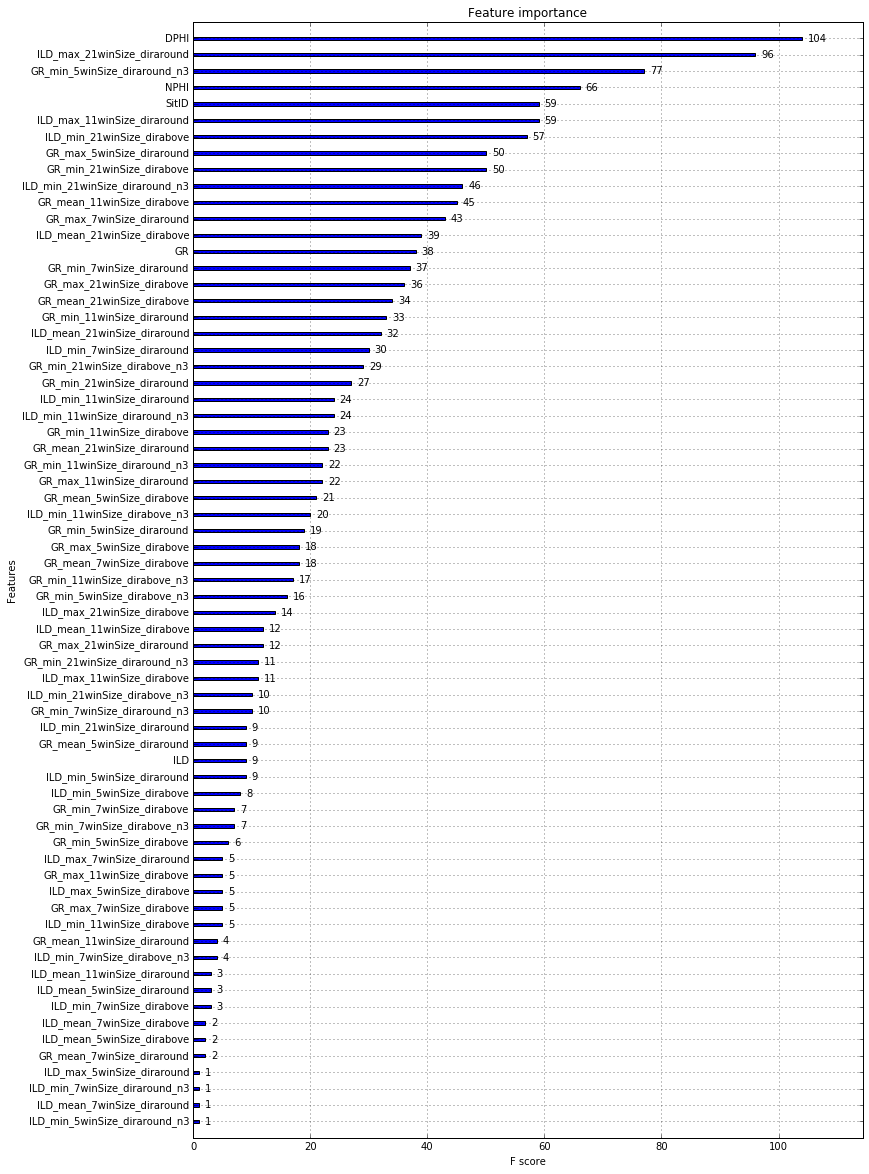

In [181]:
from xgboost import plot_importance
plot_imp = plot_importance(model)
fig = plot_imp.figure
fig.set_size_inches(12, 20)

In [182]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

,CALI,COND,DELT,DEPT,DPHI,DT,GR,GR_max_11winSize_dirabove,GR_max_11winSize_diraround,GR_max_21winSize_dirabove,...,Quality_paleoz,RHOB,SitID,UWI,UWI (AGS),new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz,Pick_pred
0,NaN,NaN,NaN,200.00,0.298,NaN,97.775,NaN,NaN,NaN,...,1,NaN,109204,00/05-12-075-05W4/0,0754051205000,166.00,0,0,205.50,-0.000078
1,NaN,NaN,NaN,200.25,0.301,NaN,96.570,NaN,NaN,NaN,...,1,NaN,109204,00/05-12-075-05W4/0,0754051205000,165.75,0,0,205.25,-0.000078
2,NaN,NaN,NaN,200.50,0.307,NaN,94.756,NaN,NaN,NaN,...,1,NaN,109204,00/05-12-075-05W4/0,0754051205000,165.50,0,0,205.00,-0.000006
3,NaN,NaN,NaN,200.75,0.309,NaN,92.944,NaN,NaN,NaN,...,1,NaN,109204,00/05-12-075-05W4/0,0754051205000,165.25,0,0,204.75,-0.000132
4,NaN,NaN,NaN,201.00,0.302,NaN,92.952,NaN,NaN,NaN,...,1,NaN,109204,00/05-12-075-05W4/0,0754051205000,165.00,0,0,204.50,-0.000105


In [183]:
len(test_df_pred.UWI.unique())

160

In [184]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 78.24154674479797


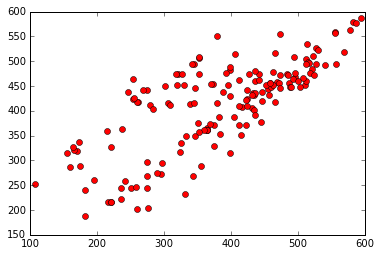

In [185]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

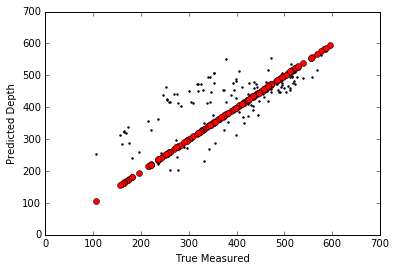

In [186]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [187]:
#test_df_pred2['new_pick_paleoz']

In [154]:
#plt.scatter(test_df_pred2['DEPT'],test_df_pred2['new_pick_paleoz'], s=2)
#plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
##plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
#plt.xlabel('base pick actual')
#plt.ylabel('Predicted Depth')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x17c6cc860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12cf0c278>]], dtype=object)

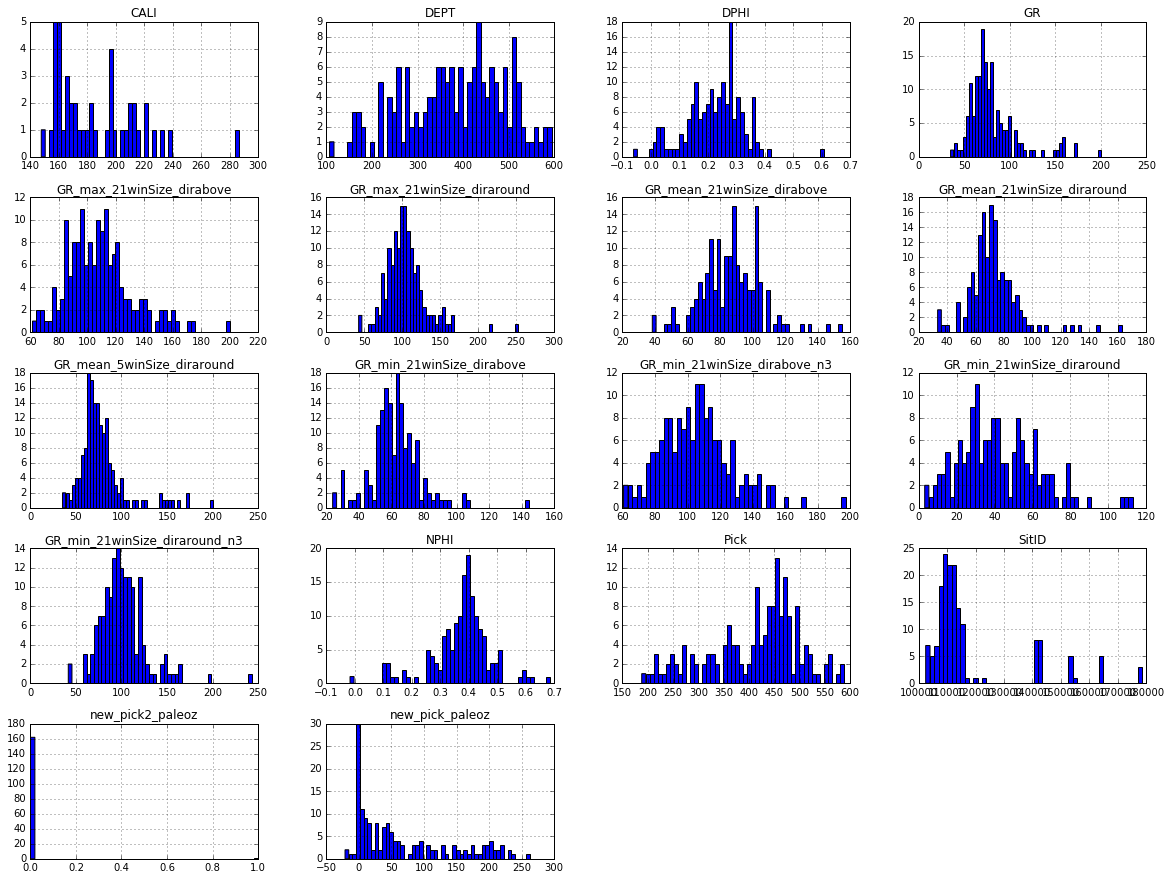

In [155]:
display= ['CALI','DEPT','DPHI','GR','NPHI', 'SitID','new_pick_paleoz','new_pick2_paleoz','Pick',
         'GR_mean_5winSize_diraround',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
         ]
df_display=test_df_pred2[display]
df_display.hist(bins=50, figsize=(20,15))

In [156]:
#tracks = ['CALI', 'GR', 'DPHI', 'NPHI', 'ILD']
#w = Well.from_las(test_df_pred2)
#w.plot(tracks=tracks)

In [157]:
## this well exists in the dataframe used in training?   '00/04-13-077-05W4/0'


In [158]:
test_df_pred2.UWI.unique()

array(['00/05-12-075-05W4/0', '00/10-09-078-09W4/0', '00/07-11-078-17W4/0',
       '00/10-25-072-09W4/0', '00/08-16-069-07W4/0', '00/06-25-078-25W4/0',
       '00/04-20-084-15W4/0', '00/10-15-072-02W5/0', '00/07-35-070-11W4/0',
       '00/10-11-076-08W4/0', '00/10-06-076-07W4/0', '00/05-15-080-11W4/0',
       '00/02-29-073-15W4/0', '00/07-19-077-19W4/0', '00/06-20-069-16W4/0',
       '00/07-01-079-24W4/0', '00/06-36-085-23W4/0', '00/07-34-081-05W4/0',
       '00/07-33-073-16W4/0', '00/06-26-068-07W4/0', '00/07-34-074-12W4/0',
       '00/11-02-071-15W4/0', '00/10-32-073-11W4/0', '00/06-07-073-11W4/0',
       '00/10-13-077-15W4/0', '00/05-29-068-07W4/0', '00/10-33-071-18W4/0',
       '00/10-21-082-13W4/0', '00/07-34-083-16W4/0', '00/01-28-078-02W4/0',
       '00/11-04-074-15W4/0', '00/10-23-071-08W4/0', '00/04-23-085-17W4/0',
       '00/07-35-078-10W4/0', '00/07-09-075-06W4/0', '00/04-26-077-15W4/0',
       '00/10-22-073-18W4/0', '00/10-14-082-06W4/0', '00/01-27-079-23W4/0',
       '00/1

In [ ]:
#'00/10-09-078-09W4/0'
#l_df = lasio.read(file).df()
#'./SPE_006_originalData/OilSandsDB/Logs/*.LAS'

#exp_l_df = lasio.read('./SPE_006_originalData/OilSandsDB/Logs/'+'00/10-09-078-09W4/0'+'.LAS').df()
#df_pred_well = test_df_pred2[test_df_pred2['UWI'] == '00/10-09-078-09W4/0']


In [99]:
df_pred_well = test_df_pred2[test_df_pred2['UWI'] == '00/10-09-078-09W4/0']
df_pred_well

,CALI,DELT,DEPT,DPHI,DT,GR,GR_max_11winSize_dirabove,GR_max_11winSize_diraround,GR_max_21winSize_dirabove,GR_max_21winSize_diraround,...,Quality_paleoz,RHOB,SitID,UWI,UWI (AGS),new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz,Pick_pred
330,NaN,NaN,262.332,0.316,NaN,81.974,81.974,84.395,81.974,91.51,...,1,0.0,111022,00/10-09-078-09W4/0,0784090910000,86.968,0,0,135.738,0.006541


In [100]:
well_path = 'SPE_006_originalData/OilSandsDB/Logs/'
w = Well.from_las(well_path+'00-10-09-078-09W4-0.LAS')
w

In [101]:
print(type(w))

<class 'welly.well.Well'>


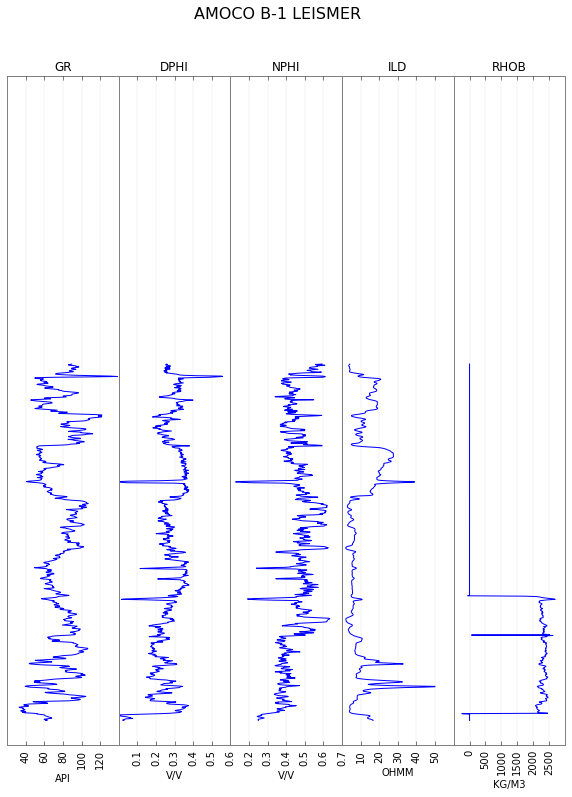

In [102]:
tracks = ['GR', 'DPHI', 'NPHI', 'ILD','RHOB']
w.plot(tracks=tracks)

In [74]:
#w_df = w.df()
print(type(w))

<class 'welly.well.Well'>


In [103]:
#w_df = w.df()
#w_df

AttributeError: 'Well' object has no attribute 'df'

In [104]:
#w = Well.from_las(well_path+'00-10-09-078-09W4-0.LAS')
w_2 = lasio.read(well_path+'00-10-09-078-09W4-0.LAS')
w_df = w_2.df()
print(type(w_df))

<class 'pandas.core.frame.DataFrame'>


In [105]:
merged_df_of_well =  pd.concat([w_df, df_pred_well], axis=1)
merged_df_of_well.head()


,RHOB,GR,DPHI,NPHI,ILD,CALI,DELT,DEPT,DPHI,DT,...,Quality_paleoz,RHOB,SitID,UWI,UWI (AGS),new_pick,new_pick2,new_pick2_paleoz,new_pick_paleoz,Pick_pred
179.832,0.0,89.392,0.256,0.593,4.191,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.082,0.0,87.675,0.261,0.557,4.002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.332,0.0,85.737,0.252,0.561,3.806,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.582,0.0,86.882,0.262,0.608,3.632,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180.832,0.0,92.636,0.270,0.580,3.625,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
merged_df_of_well = merged_df_of_well['DEPT','GR','Pick']

KeyError: ('DEPT', 'GR', 'Pick')

In [106]:
w_2.set_data_from_df(merged_df_of_well, truncate=False)    # triggers LASFile to create a new CurveItem - otherwise it'll be silently ignored.



In [107]:
print(type(w_2))

<class 'lasio.las.LASFile'>


In [114]:
w_2

AttributeError: 'LASFile' object has no attribute 'plot'

In [108]:
fn = "scratch.las"
with open(fn, mode="w") as f: # Write LAS file to disk
    w_2.write(f)

In [111]:
#w_2asdfasdf = lasio.read("scratch.las")
#w_2asdfasdf

In [112]:
#w_new = Well.from_las("scratch.las")

In [88]:
w_new.plot(tracks=tracks)

AttributeError: 'LASFile' object has no attribute 'plot'